# Detección del target y entidades


In [ ]:
import pandas as pd
import re
from matplotlib import pyplot as plt
!pip3 install stanza
import stanza
stanza.download('es')
nlp = stanza.Pipeline(lang='es', processors='tokenize, mwt, pos, lemma, depparse, ner')

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 574 kB 6.4 MB/s 
     |████████████████████████████████| 4.4 MB 44.7 MB/s 
     |████████████████████████████████| 175 kB 56.6 MB/s 
     |████████████████████████████████| 6.6 MB 44.0 MB/s 
     |████████████████████████████████| 596 kB 50.7 MB/s 
     |████████████████████████████████| 101 kB 13.5 MB/s 
  Created wheel for emoji: filename=emoji-1.7.0-py3-none-any.whl size=171046 sha256=202ebf6df7495b07272a79515328bf3515941bcf0e7086022bf3a9603029bd2f
  Stored in directory: /root/.cache/pip/wheels/8a/4e/b6/57b01db010d17ef6ea9b40300af725ef3e210cb1acfb7ac8b6
Successfully built emoji
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


2022-06-28 15:17:43 INFO: Downloading default packages for language: es (Spanish)...


2022-06-28 15:17:52 INFO: Finished downloading models and saved to /root/stanza_resources.


2022-06-28 15:17:54 INFO: Loading these models for language: es (Spanish):
| Processor | Package |
-----------------------
| tokenize  | ancora  |
| mwt       | ancora  |
| pos       | ancora  |
| lemma     | ancora  |
| depparse  | ancora  |
| ner       | conll02 |

2022-06-28 15:17:54 INFO: Use device: gpu
2022-06-28 15:17:54 INFO: Loading: tokenize
2022-06-28 15:18:06 INFO: Loading: mwt
2022-06-28 15:18:06 INFO: Loading: pos
2022-06-28 15:18:07 INFO: Loading: lemma
2022-06-28 15:18:07 INFO: Loading: depparse
2022-06-28 15:18:07 INFO: Loading: ner
2022-06-28 15:18:10 INFO: Done loading processors!


## Corpus TFM

In [ ]:
df = pd.read_csv("data_twitter/tweets_finanzas.csv", delimiter=";")
df["Tweet"] = df["Tweet"].apply(lambda x: re.sub(r'http\S+', '',x))
df["Tweet"] = df["Tweet"].apply(lambda x: re.sub(r'[^\w\s]', '', x.strip()))
list_tweets = df["Tweet"].tolist()
list_targets = df["Target"].tolist()

In [ ]:
def analisis(text):
    dict_analisis = {
        'nsubj' : [],
        'obj' : []
    }
    list_words = []
    for sent in  nlp(text).sentences:
        for word in sent.words:
            if word.deprel  == "nsubj":
                dict_analisis["nsubj"].append(word.text)
                list_words.append(word.text)
            elif word.deprel  == "obj":
                dict_analisis["obj"].append(word.text)
                list_words.append(word.text)
    #return indirect_object, Object, clausal_subject,nominal_subject
    return dict_analisis

In [ ]:
# Definimos la función que extraerá la entidad y su tipo
def entidadesText(text):
  dict_ent = {
      'PER' : [],
      'ORG' : [],
      'LOC' : [],
      'MISC' : []
  }
  listEnt= nlp(text).ents
  for ent in nlp(text).ents:
    if ent.type == "PER":
      dict_ent["PER"].append(ent.text)
    elif ent.type == "ORG":
      dict_ent["ORG"].append(ent.text)
    elif ent.type == "LOC":
      dict_ent["LOC"].append(ent.text)
    elif ent.type == "MISC":
      dict_ent["MISC"].append(ent.text) 

  #listEnt= [(ent.text, ent.type) for ent in nlp(text).ents]
  return dict_ent

In [ ]:
def get_target_ent(list_texts, list_target):
  col_pred_target = []
  col_dependencia = []
  col_pred_ent = []
  k = 0
  target = False
  ent = False

  for text in list_texts:
    text_analisis = analisis(text)
    # Comprobamos que el target esté en la lista extraída del análisis,
    # sino es así añadimos 'None' para indicar que el target no se ha identificado
    for key in text_analisis.keys():
      for word in text_analisis[key]:
        if (word in list_target[k]):
          target = True
          pred_traget = word
          col_pred_target.append(word)
          col_dependencia.append(key)
          break
      else:
        continue
      break

    if not target:
      col_pred_target.append('None')
      col_dependencia.append('None')
      col_pred_ent.append('None')

    text_entidades = entidadesText(text)
    if target:
      for key in text_entidades.keys():
        for word in text_entidades[key]:
          if (word == list_target[k]):
            ent = True
            col_pred_ent.append(key)
            break
        else:
          continue
        break
      
      if not ent:
        col_pred_ent.append("OTHER")

    ent =False  
    target = False
    k = k+1

  return col_pred_target, col_dependencia, col_pred_ent

In [ ]:
cols_target_ent = get_target_ent(list_tweets, list_targets)

In [ ]:
df_ent = df.loc[:, ["Tweet", "Target"]]
df_ent["pred_target"] = cols_target_ent[0]
df_ent["dependencia"] = cols_target_ent[1]
df_ent["pred_entidad"] = cols_target_ent[2]
df_ent.to_csv("data_twitter/tweets_finanzas_entidades.csv", sep=';', index=False)

Text(0.5, 1.0, 'Distribución de las entidades del target')

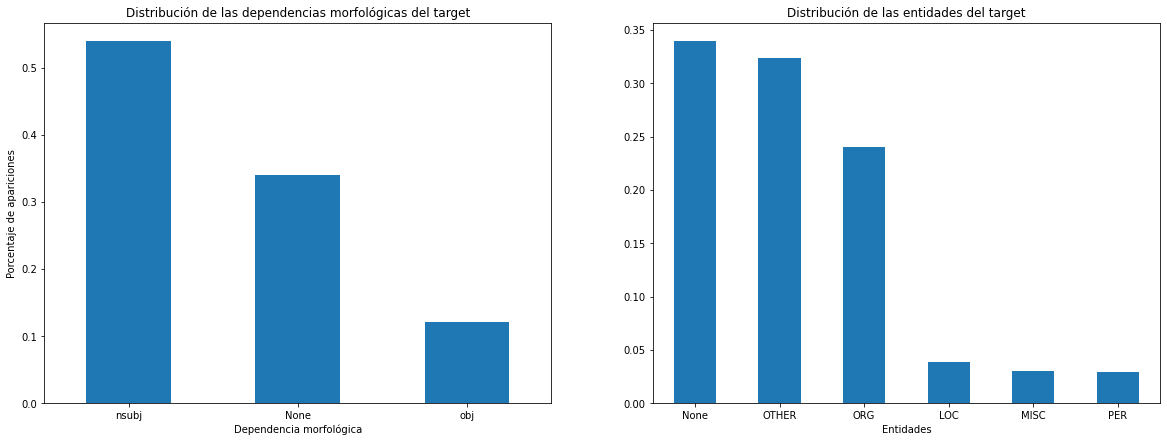

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,7))

df_ent['dependencia'].value_counts(normalize=True).plot(kind='bar', ax=ax1)
ax1.tick_params(labelrotation=0)
ax1.set(ylabel='Porcentaje de apariciones', xlabel='Dependencia morfológica')
ax1.set_title(("Distribución de las dependencias morfológicas del target"))

df_ent['pred_entidad'].value_counts(normalize=True).plot(kind='bar', ax=ax2)
ax2.tick_params(labelrotation=0)
ax2.set(xlabel="Entidades")
ax2.set_title(("Distribución de las entidades del target"))

In [ ]:
print("Distribución de las dependencias morfológicas del target:\n")
print(df_ent['dependencia'].value_counts(normalize=True)*100)
print("---------------------------------------------------------")
print("Distribución de las entidades del target:\n")
print(df_ent['pred_entidad'].value_counts(normalize=True)*100)

Distribución de las dependencias morfológicas del target:

nsubj    53.960784
None     33.960784
obj      12.078431
Name: dependencia, dtype: float64
---------------------------------------------------------
Distribución de las entidades del target:

None     33.960784
OTHER    32.313725
ORG      24.000000
LOC       3.843137
MISC      2.980392
PER       2.901961
Name: pred_entidad, dtype: float64


## Corpus proporcionado

In [ ]:
df2 = pd.read_csv("data_web/economy-dataset.csv")
df2 = df2.dropna()
df2["Heading"] = df2["Heading"].apply(lambda x: re.sub(r'[^\w\s]', '', x.strip()))
df2["Heading"] = df2["Heading"].apply(lambda x: re.sub('[0-9]+', '', x))
df2["Target"] = df2["Target"].apply(lambda x: re.sub('[0-9]+', '', str(x)))
list_tweets2 = df2["Heading"].tolist()
list_targets2 = df2["Target"].tolist()

In [ ]:
cols_target_ent2 = get_target_ent(list_tweets2, list_targets2)

In [ ]:
df2_ent = df2.loc[:, ["Heading", "Target"]]
df2_ent["pred_target"] = cols_target_ent2[0]
df2_ent["dependencia"] = cols_target_ent2[1]
df2_ent["pred_entidad"] = cols_target_ent2[2]
df2_ent.to_csv("data_web/headings_finanzas_entidades.csv", index=False)

Text(0.5, 1.0, 'Distribución de las entidades del target')

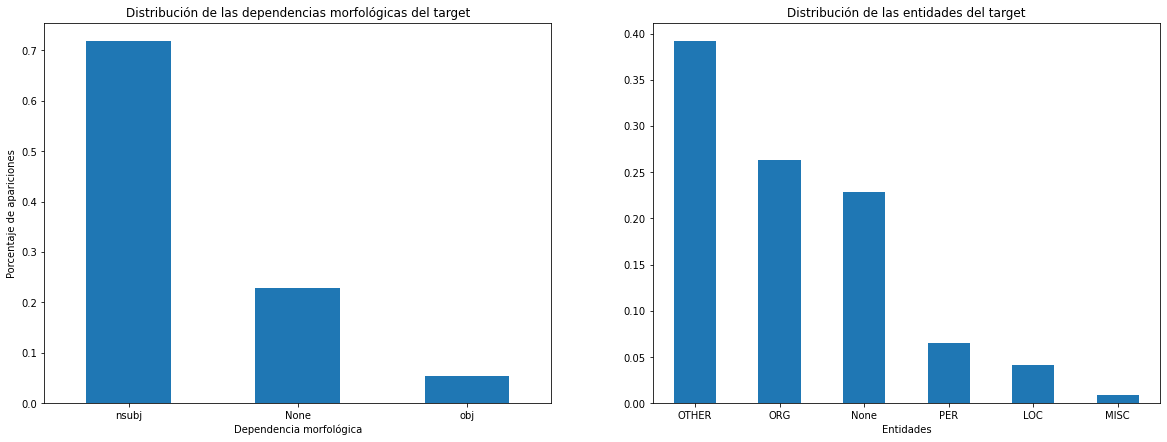

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,7))

df2_ent['dependencia'].value_counts(normalize=True).plot(kind='bar', ax=ax1)
ax1.tick_params(labelrotation=0)
ax1.set(ylabel='Porcentaje de apariciones', xlabel='Dependencia morfológica')
ax1.set_title(("Distribución de las dependencias morfológicas del target"))

df2_ent['pred_entidad'].value_counts(normalize=True).plot(kind='bar', ax=ax2)
ax2.tick_params(labelrotation=0)
ax2.set(xlabel="Entidades")
ax2.set_title(("Distribución de las entidades del target"))

In [ ]:
print("Distribución de las dependencias morfológicas del target:\n")
print(df2_ent['dependencia'].value_counts(normalize=True)*100)
print("---------------------------------------------------------")
print("Distribución de las entidades del target:\n")
print(df2_ent['pred_entidad'].value_counts(normalize=True)*100)

Distribución de las dependencias morfológicas del target:

nsubj    71.850220
None     22.819383
obj       5.330396
Name: dependencia, dtype: float64
---------------------------------------------------------
Distribución de las entidades del target:

OTHER    39.207048
ORG      26.343612
None     22.819383
PER       6.563877
LOC       4.140969
MISC      0.925110
Name: pred_entidad, dtype: float64
